In [155]:
# Libraries
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import requests



In [3]:
data_graffiti = pd.read_csv('graffiti.csv')
data_pot_holes = pd.read_csv('pot_holes.csv')
data_sanitation = pd.read_csv('sanitation.csv')
data_vacant = pd.read_csv('vacant.csv')


In [4]:
graff = {"creation_date": list(data_graffiti["Creation Date"]),
         "completion_time": list(data_graffiti["Completion Date"]),
         "latitude": data_graffiti["Latitude"],
         "longitude": data_graffiti["Longitude"],
         "request_type": list(data_graffiti["Type of Service Request"]),
         "zip_code": data_graffiti["ZIP Code"]}

In [5]:
vacant = {"creation_date": list(data_vacant["DATE SERVICE REQUEST WAS RECEIVED"]),
         "completion_time": [float("NaN")]*data_vacant.shape[0],
         "latitude": data_vacant["LATITUDE"],
         "longitude": data_vacant["LONGITUDE"],
         "request_type": list(data_vacant["SERVICE REQUEST TYPE"]),
         "zip_code": data_vacant["ZIP CODE"]}

In [6]:
pot_holes = {"creation_date": list(data_pot_holes["CREATION DATE"]),
         "completion_time": list(data_pot_holes["COMPLETION DATE"]),
         "latitude": data_pot_holes["LATITUDE"],
         "longitude": data_pot_holes["LONGITUDE"],
         "request_type": list(data_pot_holes["TYPE OF SERVICE REQUEST"]),
         "zip_code": data_pot_holes["ZIP"]}

In [7]:
sanitation = {"creation_date": list(data_sanitation["Creation Date"]),
         "completion_time": list(data_sanitation["Completion Date"]),
         "latitude": data_sanitation["Latitude"],
         "longitude": data_sanitation["Longitude"],
         "request_type": list(data_sanitation["Type of Service Request"]),
         "zip_code": data_sanitation["ZIP Code"]}

In [8]:
df_graff = pd.DataFrame(graff)
df_vacant = pd.DataFrame(vacant)
df_pot_holes = pd.DataFrame(pot_holes)
df_sanitation = pd.DataFrame(sanitation)


In [9]:
complete = pd.concat([df_graff, df_vacant, df_pot_holes, df_sanitation], axis=0)

# Type of Requests by Zip Code

In [10]:
def categorize(df):
    
    floats = df.dtypes[df.dtypes == "float64"].index
    for i in floats:
        df[i] = df[i].astype(str)
    
    ints = df.dtypes[df.dtypes == "int64"].index
    for i in ints:
        df[i] = df[i].astype(str)

    objects = df.dtypes[df.dtypes == "object"].index
    for i in objects:
        df[i] = df[i].astype("category")
    return df

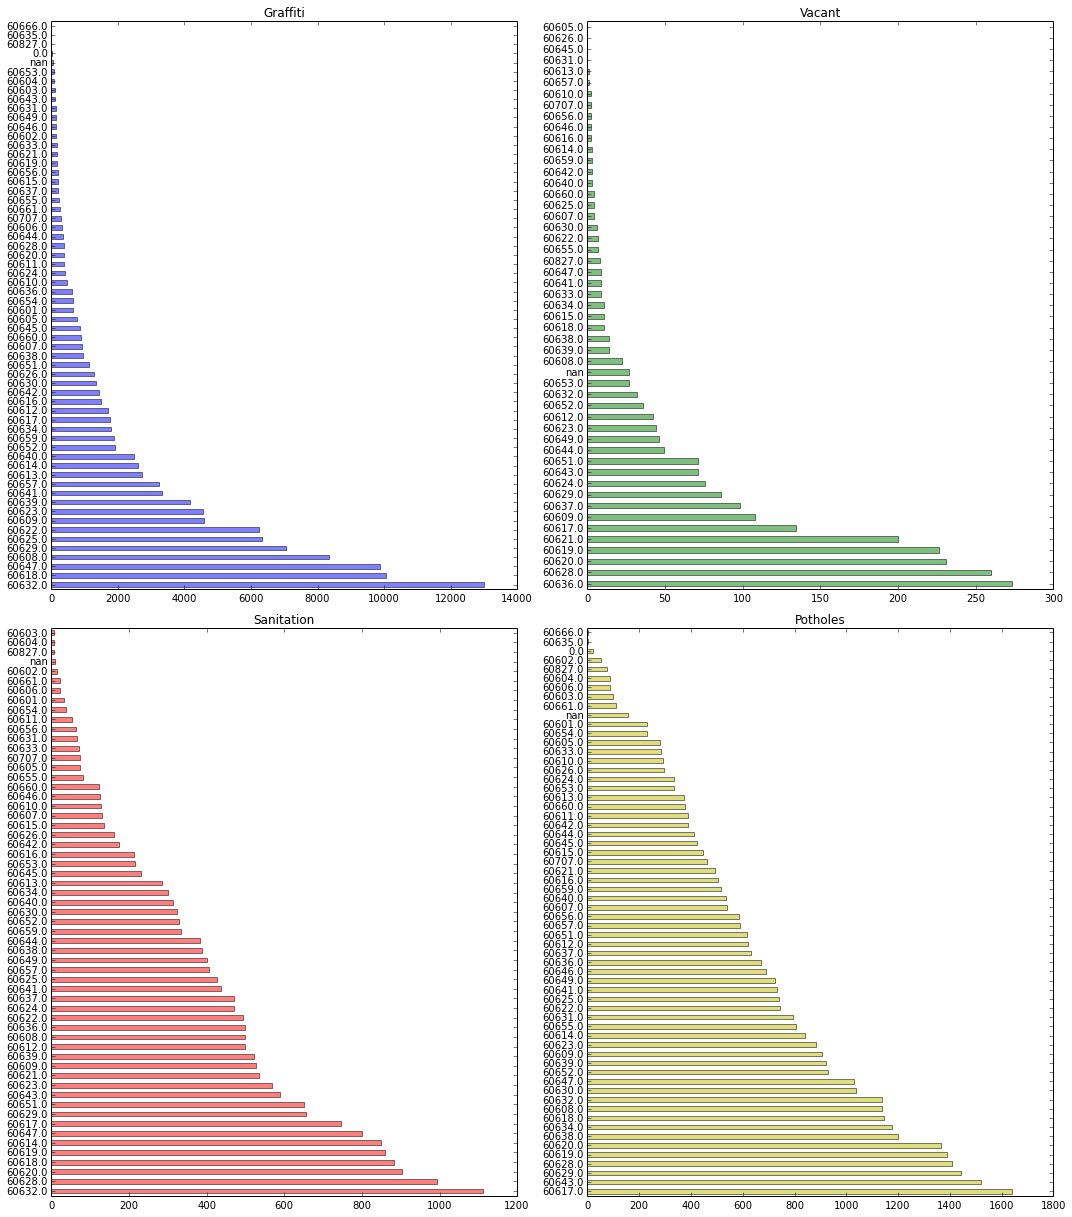

In [11]:
# Zip code distribution by request type
graff_cats = categorize(data_graffiti).dropna()
vacant_cats = categorize(data_vacant).dropna()
sanitation_cats = categorize(data_sanitation).dropna()
pothole_cats = categorize(data_pot_holes).dropna()
# Counts for Zip Codes
h1 = graff_cats["ZIP Code"].value_counts().to_frame()
h2 = vacant_cats["ZIP CODE"].value_counts().to_frame()
h3 = sanitation_cats["ZIP Code"].value_counts().to_frame()
h4 = pothole_cats["ZIP"].value_counts().to_frame()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 17))
h1["ZIP Code"].plot(kind="barh", alpha=0.5, ax=axes[0,0]); axes[0,0].set_title('Graffiti')
h2["ZIP CODE"].plot(kind="barh", alpha=0.5, ax=axes[0,1], color="g"); axes[0,1].set_title('Vacant')
h3["ZIP Code"].plot(kind="barh", alpha=0.5, ax=axes[1,0], color="r"); axes[1,0].set_title('Sanitation')
h4["ZIP"].plot(kind="barh", alpha=0.5, ax=axes[1,1], color="y"); axes[1,1].set_title('Potholes')
fig.tight_layout()


## Create one Dataframe for analysis

In [12]:
# Compute total counts by request time and creation_date
counts = complete.groupby( [ "creation_date", "request_type"] )
counts = counts.size().to_frame().reset_index()
counts = counts.rename(columns={0 : "total"})
counts = counts.sort_values(by = "creation_date")
#counts["creation_date"] = pd.to_datetime(counts["creation_date"] )

In [13]:
def filter_func(df,type):
    if type == "graffiti":
        I = df['request_type'].str.contains("Graffiti Removal")
    elif type == "vacant":
        I = df['request_type'].str.contains("Vacant/Abandoned Building")
    elif type == "potholes":
        I = df['request_type'].str.contains("Pothole in Street")
    else:
        I = df['request_type'].str.contains("Sanitation Code Violation")
    return df[I]

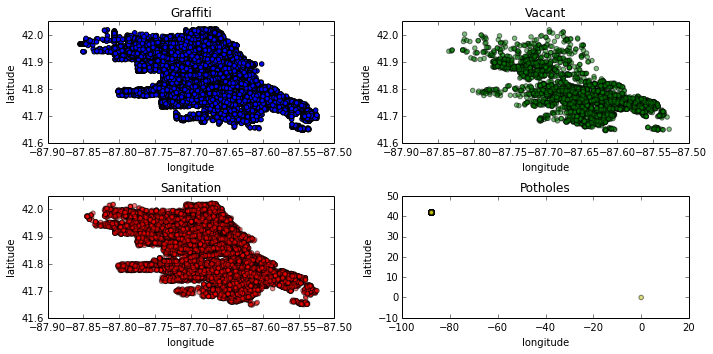

In [76]:
# Location of total requests by request type
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
filter_func(complete, "graffiti").plot(kind='scatter', x='longitude', y='latitude', ax=axes[0,0]); axes[0,0].set_title('Graffiti')
filter_func(complete, "vacant").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color ="g", ax=axes[0,1]); axes[0,1].set_title('Vacant')
filter_func(complete, "sanitation").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color="r", ax=axes[1,0]); axes[1,0].set_title('Sanitation')
filter_func(complete, "potholes").plot(kind='scatter', x='longitude', y='latitude', alpha = 0.5, color="y", ax=axes[1,1]); axes[1,1].set_title('Potholes')
fig.tight_layout()



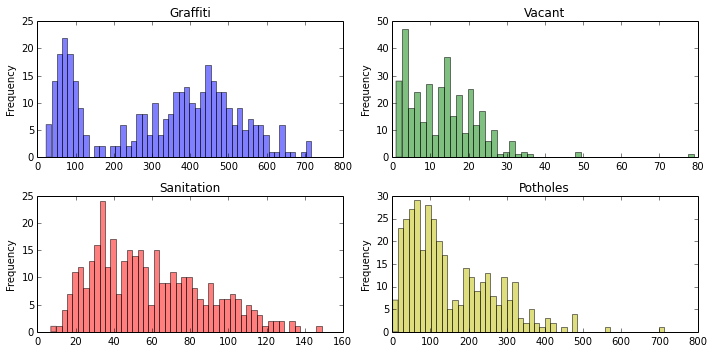

In [77]:
# Distribution of requestes during March 2016 to March 2017

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

filter_func(counts, "graffiti")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[0,0]); axes[0,0].set_title('Graffiti')
filter_func(counts, "vacant")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[0,1], color ="g"); axes[0,1].set_title('Vacant')
filter_func(counts, "sanitation")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[1,0], color="r"); axes[1,0].set_title('Sanitation')
filter_func(counts, "potholes")["total"].plot('hist', bins=50, alpha = 0.5, ax=axes[1,1], color="y"); axes[1,1].set_title('Potholes')
fig.tight_layout()

In [104]:
# Summary of Graffiti Requests during March 2016- March 2017
filter_func(counts, "graffiti").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,364.0,321.527473,186.849011,23.0,102.75,363.5,466.0,717.0


In [105]:
# Summary of Vacant/ Building Requests during March 2016- March 2017
filter_func(counts, "vacant").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,361.0,13.174515,9.173937,1.0,5.0,13.0,19.0,79.0


In [106]:
#  Summary of Sanitation Requests during March 2016- March 2017
filter_func(counts, "sanitation").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,364.0,58.912088,29.046329,7.0,35.0,54.0,78.0,149.0


In [107]:
# Summary of Potholes Requests during March 2016- March 2017
filter_func(counts, "potholes").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total,365.0,152.315068,114.737766,1.0,63.0,116.0,229.0,713.0


In [108]:
# Function from Stackeoverflow to make datetime function faster
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [109]:
def response_time(df, type):
    """
    Given a dataframe, computes the difference between creation date
    and completion time for the request. It adds an extra column with
    the difference to the dataframe in hours
    Input: dataframe and request tyoe (string)
    Returns: Modified dataframe
    """
    df_g = filter_func(complete, type).sort_values(by = "creation_date")
    df_g["creation_date"] = lookup(df_g["creation_date"] )
    df_g["completion_time"] = lookup(df_g["completion_time"] )
    df_g['difference'] = df_g['creation_date'].sub(df_g['completion_time'], axis=0)
    df_g['difference'] = df_g['difference'] / np.timedelta64(1, 'D')*-1
    del df_g["latitude"]
    del df_g["longitude"]
    return df_g

In [110]:
response_time(complete, "graffiti").describe().transpose()


,count,mean,std,min,25%,50%,75%,max
zip_code,116981.0,60605.973885,1175.720607,0.0,60618.0,60629.0,60640.0,60827.0
difference,116882.0,0.667904,1.021351,-0.0,-0.0,-0.0,1.0,25.0


In [111]:
response_time(complete, "potholes").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
zip_code,55385.0,60570.477674,1944.239111,0.0,60619.0,60631.0,60643.0,60827.0
difference,52631.0,23.662784,35.590511,-0.0,2.0,8.0,30.0,321.0


In [112]:
response_time(complete, "sanitation").describe().transpose()

,count,mean,std,min,25%,50%,75%,max
zip_code,21435.0,60630.205738,15.197371,60601.0,60619.0,60628.0,60641.0,60827.0
difference,21202.0,8.881851,13.951351,-0.0,2.0,4.0,11.0,183.0


3. Based on	these summary statistics, tell me 5 interesting things you	learned	using the 311 data.
   i) According to the maps, Graffiti and Sanitation reports are ubiquitous in the city of Chicago, while pothole        requests seemed to be very focalized to certain neighborhoods.
   ii) The distribution of Graffiti requests seems to be bimodal. The first mode is between 50-60 requests and 
       the second one is around 250. Additionally, the average number of graffiti requests is huge!! 321.5.
   iii) From the four types of requests, vacant and abandoned buildings was the one with the fewest average requests,
         13.17, during 2016-2017.
   iv) The average time to complete a request is the highest for potholes (23.66 days) and the lowest is for graffiti
       with an average of 16 hours.
   v) The maximum time to complete a request was for a pothole. It took almost a year, 321 days, to fix the problem.
      As we saw in the scatterplot for the coordenates of the reports, pothole requests are fairly localized. This may
      be the result of different factors: a) Traffic, b) neighborhoods with low population density, c) neighborhoods 
      with low income. Without further information, it is not possible to say more about this issue.

In [184]:
def fips_list(df, type, num, random_s):
    """
    Given a dataframe, it filters the dataframe by type for the
    last three months and retrieves the fips code for a lat/lon tuple.
    Input: dataframe and request tyoe (string)
    Returns: modified dataframe with fips column
    """
    rv = []
    block_group = []
    df_g = filter_func(complete, type).sort_values(by = "creation_date")
    df_g["creation_date"] = lookup(df_g["creation_date"] )
    df_g["completion_time"] = lookup(df_g["completion_time"])
    print(df_g.shape)
    df_g = df_g[df_g['creation_date'] >='2016-10-28']
   
    if random_s:
        # Take random sample from dataframe
        rows = np.random.choice(df_g.index.values, num)
        df_sample = df_g.ix[rows]
    else:
        df_sample = df_g

    for index,row in df_sample.iterrows():
        lati = row["latitude"]
        long = row["longitude"]
        url ="http://data.fcc.gov/api/block/find?format=json&latitude={lat}&longitude={lon}&showall=false".format(lat =lati, lon =long)
        r = requests.get(url)
        d = r.json()
        fips = d["Block"]["FIPS"]
        rv.append(fips)
        block_group.append(int(fips[-1]))
    fips = pd.Series(rv)
    bg = pd.Series(block_group)
    
    df_sample = df_sample.reset_index()
    new = pd.concat((df_sample,fips), axis=1)
    new = new.rename(columns={0 : "fips"})
    new = pd.concat((new, bg), axis=1)
    new = new.rename(columns={0 : "block_group"})
    return new

In [101]:
def get_census_vars(df):
    """
    Function that retrieves the INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)!!
    Total households based on a FIPS
    """
    
    income_list = []
  
    for index, row in df.iterrows():
        state = row['fips'][0:2]
        county = row['fips'][2:5]
        tract = row['fips'][5:11]

        url ="http://api.census.gov/data/2015/acs5/profile?get=DP03_0051E,NAME&for=tract:{tract}&in=state:{state}+county:{county}".format(state=state, county= county, tract=tract)
        #url = "http://api.census.gov/data/2015/acs5?get=NAME,B01001_002E&for=block+group:{a}&in=state:{b}&in=county:{c}&in=tract:{d}".format(a=block, b=state, c=county, d=tract)
        print(url)
        r = requests.get(url)
        print(r.status_code)
        if r.status_code!=204:
            json = r.json()
            household_income= json[1][0]

            income_list.append(household_income)

   

    #income = pd.Series(income_list)
    #um_rate = pd.Series(urate_list)


   
    return income_list

In [185]:
vacants_sample =fips_list(complete,"vacant", 200, True)
sanitation_sample =fips_list(complete,"sanitation", 200, True)

(4756, 6)
(21444, 6)


# Block Groups 

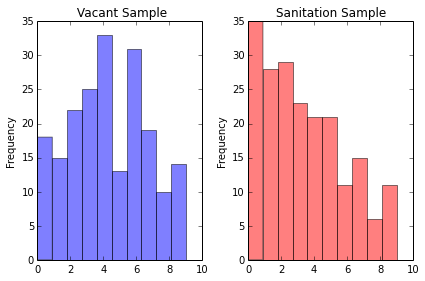

In [186]:

plt.figure()
figsize=(10, 10)
ax=plt.subplot(121)
vacants_sample.block_group.plot(kind = "hist", alpha = 0.5, ax=ax); ax.set_title(' Vacant Sample')
ax=plt.subplot(122)
sanitation_sample.block_group.plot(kind = "hist", alpha = 0.5, ax=ax, color="r"); ax.set_title('Sanitation Sample')
plt.tight_layout()

In [187]:
def add_months(df):
    """
    Add month column to a dataframe
    """
    month_list = []

    for i in df["creation_date"]:
       if type(i) != float:

           month_list.append(i.month)

    df_months = pd.DataFrame({"month": month_list})
    df = pd.concat([df,df_months], axis=1)
    return df

In [188]:
vacants_sample = add_months(vacants_sample)
sanitation_sample = add_months(sanitation_sample)

## Change of Block Groups Over Time

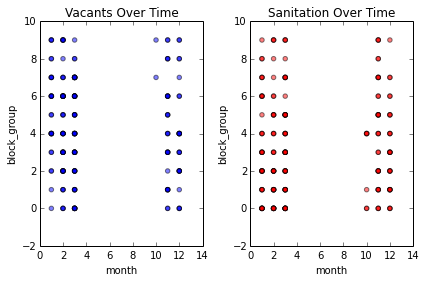

In [189]:
plt.figure()
figsize=(10, 10)
ax=plt.subplot(121)
vacants_sample.plot(kind ="scatter", x ="month", y="block_group", ax=ax, alpha =0.5); ax.set_title("Vacants Over Time")
ax=plt.subplot(122)
sanitation_sample.plot(kind ="scatter", x ="month", y="block_group", ax=ax, alpha=0.5, color="r"); ax.set_title("Sanitation Over Time")
plt.tight_layout()

### From the sample for the vacants and sanitation, we observe that, over the past six months, complaints are very similar for both categories. However, the intensity of the scatterplot shows that vacant complaints are more common during the first months of the year than sanitation complaints.

# Problem 3

## 3A

In [25]:
street = "7500 S WOLCOTT AVE"
st_graff = graff_cats["Street Address"].value_counts().to_frame()
st_graff = st_graff.rename(columns={"Street Address" : "total"})
st_graff.street.loc["5000 N ELSTON AVE"]

65

In [27]:
for i in st_graff.index:
    if i == street:
        rv = st_graff.total.loc[street]
    else:
        rv = 0

In [28]:
rv

0

In [47]:
vacant_cats["street"] = vacant_cats[['ADDRESS STREET NUMBER', 'ADDRESS STREET DIRECTION', 'ADDRESS STREET NAME', 'ADDRESS STREET SUFFIX']].apply(lambda x: ' '.join(x), axis=1)
vacant_cats["street"] = vacant_cats["street"].astype("category")
st_vacant = vacant_cats["street"].value_counts().to_frame()
st_vacant = st_vacant.rename(columns={"Street Address" : "total"})

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [50]:
for i in st_vacant.index:
    if i == street:
        rv = st_vacant.total.loc[street]
        break
    else:
        rv = 0

In [51]:
rv

0

In [53]:
st_sanitation = sanitation_cats["Street Address"].value_counts().to_frame()
st_sanitation = st_sanitation.rename(columns={"Street Address" : "total"})


In [55]:
for i in st_sanitation.index:
    if i == street:
        rv = st_sanitation.total.loc[street]
        break
    else:
        rv = 0

In [56]:
rv

0

In [66]:
st_potholes = pothole_cats["STREET ADDRESS"].value_counts().to_frame()
st_potholes = st_potholes.rename(columns={"STREET ADDRESS" : "total"})

In [69]:
for i in st_potholes.index:
    if i == street:
        print(i)
        rv = st_potholes.total.loc[street]
        break
    else:
        rv = 0

7500 S WOLCOTT AVE


In [70]:
rv

1

In [63]:
st_potholes.total.loc[street]

1

The request that is most likely is a pot holes request, since this street is only present in this dataframe.
However, the probability is very small and is close to zero.

In [73]:
rv/pothole_cats.shape[0]

2.5708923567370234e-05

## 3B

### Zip codes for Lawndale parts of 60608, 60623 and 60624
### Zip codes for Uptown parts of 60613, 60640

In [ ]:
h1 = graff_cats["ZIP Code"].value_counts().to_frame()
h2 = vacant_cats["ZIP CODE"].value_counts().to_frame()
h3 = sanitation_cats["ZIP Code"].value_counts().to_frame()
h4 = pothole_cats["ZIP"].value_counts().to_frame()

In [99]:
def zip_codes(type):
    """
    Compute total counts for zip codes
    Input: A string specifying the request type
    Returns: A dataframe with the counts
    """
    lawndale = ["60608.0", "60623.0", "60624.0"]
    uptown = ["60613.0", "60640.0"]
    
    if type =="graff":
        zips = graff_cats["ZIP Code"].value_counts().to_frame()
        zips = zips.rename(columns={"ZIP Code" : "total"})
    
    l_count = 0
    u_count = 0
    
    for i in zips.index:
        if i in lawndale:
            l_count = zips.total.loc[i] + l_count
        if i in uptown:
            u_count = zips.total.loc[i] + u_count
    
    
    return u_count, l_count

## Call likelihood graffiti

In [100]:
(zip_codes("graff")[0]/graff_cats.shape[0])*100

4.4862493238428049

In [101]:
(zip_codes("graff")[1]/graff_cats.shape[0])*100

11.407523161067083

The call is more likely to come from Lawndale

# 3C

## Bayes Rule example for Englewood 
$$ P(E \mid G) = \frac{P(G \mid E) \, P(E)}{P(G)} $$

## where E stands for Englewood and G for Graffiti

$$P(G) =P(G \mid E) \, P(E) + P(G \mid U) \, P(U) $$


## Englewood

In [102]:
(1/6)*(6/10)/((1/6)*(6/10)+ (4/10)*(4/10))

0.3846153846153846

## Uptown

In [103]:
(4/10)*(4/10)/((1/6)*(6/10)+ (4/10)*(4/10))

0.6153846153846155

The call is more likely to come from Uptown
